# Data & Imports

In [10]:
# time meausre
import time
import math
start_time = time.time()

def print_time(execution_time):
    hours = int(math.floor(int(execution_time)/3600))
    minutes = int(math.floor((execution_time/3600-hours)*60))
    seconds = execution_time%60
    print("--- Total: %i hours, %i minutes, %f seconds  ---" % (hours,minutes,seconds))

In [11]:
import keras
import autokeras as ak
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# constants
path = 'C:/Users/Asus/Documents/2023_2/Memoria/src'
#path = 'C:/Users/Monte/Documents/Memoria/src'

# seeds
global_seed = 19
# np.random.seed(seed=global_seed) # seed gets seted by statement below
keras.utils.set_random_seed(global_seed)
tf.config.experimental.enable_op_determinism()

# Ostar
O_df = pd.read_csv(path+'/Data/o_spectral_lines_trim.csv')
# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines_trim.csv')
# Observed spectra
Obs_df = pd.read_csv(path+'/Data/observed_spectral_lines_trim_v2.csv')

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]
X_obs = Obs_df.drop(target+['HD','date','time'],axis=1)
Y_obs = Obs_df[target]

X = np.random.normal(loc=0, scale=0.01, size=X.shape) + X
y_scaler = MinMaxScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=global_seed)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.75, test_size=0.25, random_state=global_seed)

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)
y_obs = y_scaler.transform(Y_obs.values)

formatted_x_train = np.expand_dims(x_train, axis=2) #This step it's very important an CNN will only accept this data shape
formatted_x_val = np.expand_dims(x_val, axis=2)
formatted_x_test = np.expand_dims(x_test, axis=2)
formatted_x_obs = np.expand_dims(X_obs, axis=2)


c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [13]:
# Density plot function

# https://kdepy.readthedocs.io/en/latest/examples.html#minimal-working-example-with-options
from KDEpy import FFTKDE
from sklearn.neighbors import KernelDensity
import numpy as np

measure = ['Temperature','log g', 'v sini']
measure_unit = ['[K]', '[u]', '[km/s]']

def SKL_density_plot(data, ax,low_bound=None,up_bound=None,title='', color='black',alpha=1,label='',kernel='gaussian', bw='silverman',linewidth=1):
  
	if low_bound != None and up_bound != None:
		bw = FFTKDE(bw=bw, kernel='gaussian').fit(data).bw
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		data = np.concatenate((data, 2 * low_bound - data, 2 * up_bound - data))
		kde = KernelDensity(bandwidth=kde.bandwidth_, kernel=kernel).fit(data.reshape(-1,1))
		x = np.linspace(low_bound,up_bound,1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		plot_y = y[np.where((x>=low_bound) & (x<=up_bound))] # Set the KDE to zero outside of the domain
		plot_x = x[np.where((x>=low_bound) & (x<=up_bound))]  # Set the KDE to zero outside of the domain
		plot_y = plot_y * 3  # Double the y-values to get integral of ~1
		ax.plot(plot_x, plot_y, label=label,color=color,alpha=alpha,linewidth=linewidth)
		return x, y, kde
	else:
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		x=np.linspace(data.min(),data.max(),1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		ax.plot(x, y, label=label,color=color,alpha=alpha)
		return x, y, kde

# AutoModel

In [14]:
from keras_tuner.engine import hyperparameters as hp

# convBlock
conv_kernel_size = hp.Choice("kernel_size", [2,3,5],)
conv_num_layers = hp.Choice("conv_layers", [2,3],)
conv_num_blocks = hp.Choice("conv_blocks", [2,3],)
conv_filters = hp.Choice("filters", [32,64,128,256,512],)

# # DenseBlock
dense_num_layers = hp.Choice("dense_layers", [2,3])
dense_units = hp.Choice("dense_units", [128,256,384,512])

# RegressionHead
# head_dropout = hp.Float(
#                 'dropout_head',
#                 min_value=0.0,
#                 max_value=0.5,
#                 default=0.25,
#                 step=0.05,
#             )

input = ak.Input()
conv = ak.ConvBlock(
  	kernel_size=conv_kernel_size,
  	num_blocks=conv_num_blocks,
  	num_layers=conv_num_layers,
  	filters=conv_filters,
  	max_pooling=True,
		separable=False,
  	#dropout=conv_dropout,
)(input)
dense = ak.DenseBlock(
  	num_layers=dense_num_layers, 
  	num_units=dense_units, 
  	use_batchnorm=False, 
  	#dropout=dense_dropout
)(conv)
regression_output = ak.RegressionHead(
  	output_dim=3, 
   	loss="mse", 
    metrics=["mae"], 
    #dropout=head_dropout,
)(dense)


def generateAutoModel():
  return ak.AutoModel(
	inputs=input,
	outputs=regression_output,
	max_trials=200,
	loss='mse',
	metrics = 'mae',
	tuner='bayesian',
	overwrite=False,
	seed=global_seed,
	max_model_size=None,
 	project_name='greedy_approach')

model = generateAutoModel()


Reloading Tuner from .\auto_model\tuner0.json


In [15]:
# set timer
curr_time = time.time()

In [16]:
# 6 hrs, 15 min 100 modelos
# 28 hrs 500 modelos
model.fit(formatted_x_train, y_train,validation_data=(formatted_x_val, y_val), epochs=20)



Trial 6 Complete [00h 02m 24s]
val_loss: 0.08157144486904144

Best val_loss So Far: 0.014318167231976986
Total elapsed time: 3d 21h 41m 48s
Epoch 1/20
459/459 [==============================] - 6s 12ms/step - loss: 0.0990 - mae: 0.2522 - val_loss: 0.0474 - val_mae: 0.1730
Epoch 2/20
459/459 [==============================] - 5s 12ms/step - loss: 0.0527 - mae: 0.1793 - val_loss: 0.0424 - val_mae: 0.1627
Epoch 3/20
459/459 [==============================] - 6s 12ms/step - loss: 0.0416 - mae: 0.1593 - val_loss: 0.0260 - val_mae: 0.1183
Epoch 4/20
459/459 [==============================] - 5s 12ms/step - loss: 0.0366 - mae: 0.1483 - val_loss: 0.0219 - val_mae: 0.1097
Epoch 5/20
459/459 [==============================] - 6s 12ms/step - loss: 0.0346 - mae: 0.1437 - val_loss: 0.0243 - val_mae: 0.1149
Epoch 6/20
459/459 [==============================] - 6s 12ms/step - loss: 0.0330 - mae: 0.1400 - val_loss: 0.0240 - val_mae: 0.1169
Epoch 7/20
459/459 [==============================] - 5s 12ms/

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


In [17]:
# execution time print
print_time(float(time.time() - curr_time))

--- Total: 0 hours, 4 minutes, 15.987439 seconds  ---


In [18]:
exp = model.export_model()
exp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 139, 1)]          0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 139, 1)           0         
 t32)                                                            
                                                                 
 conv1d (Conv1D)             (None, 131, 128)          1280      
                                                                 
 conv1d_1 (Conv1D)           (None, 123, 512)          590336    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 512)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7680)              0     

In [19]:
# Evaluate the best model with testing data.
evaluation = model.evaluate(formatted_x_test, y_test)

print('loss: %.3f  MAE:%.3f'% (evaluation[0],evaluation[1]))

153/153 [==============================] - 1s 6ms/step - loss: 0.0172 - mae: 0.0951
loss: 0.017  MAE:0.095


In [28]:
predictions = model.predict(formatted_x_test)

153/153 [==============================] - 0s 3ms/step


In [32]:
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_test[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_test[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.027  MAE:0.122
log g -       loss: 0.022  MAE:0.119
v -           loss: 0.003  MAE:0.045


In [ ]:
# / TODO: error de perdida para cada parametro
# / TODO: grafica de valor esperado vs prediccion para espectro observado
# TODO: fijar casos borde para espectros observados(grafica)
# TODO: agregar chi a la tabla

# Prediccion de datos de testing (modelo unico)

In [11]:
predictions = y_scaler.inverse_transform(model.predict(formatted_x_test))

153/153 [==============================] - 1s 6ms/step


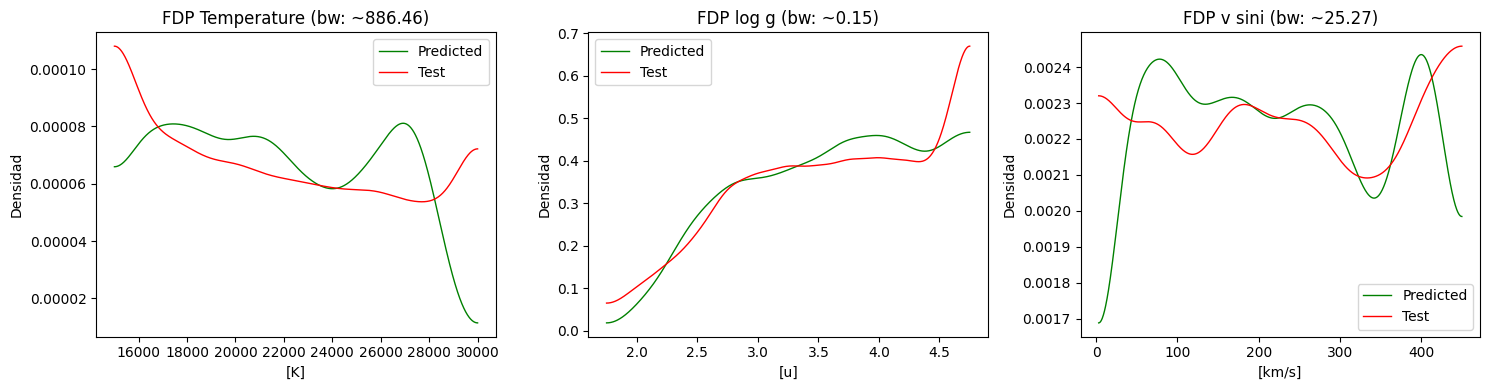

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for i, featureName in enumerate(target):
	x, y, kde = SKL_density_plot(predictions[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',label='Predicted')
	x, y, kde = SKL_density_plot(y_scaler.inverse_transform(y_test)[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color='red',label='Test')
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[u]', '[km/s]']
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel('Densidad')
	axes[i].set_title('FDP '+measure[i]+' (bw: ~%.2f'%(kde.bandwidth_)+')')
	axes[i].legend()

plt.legend()
plt.tight_layout();
plt.show()

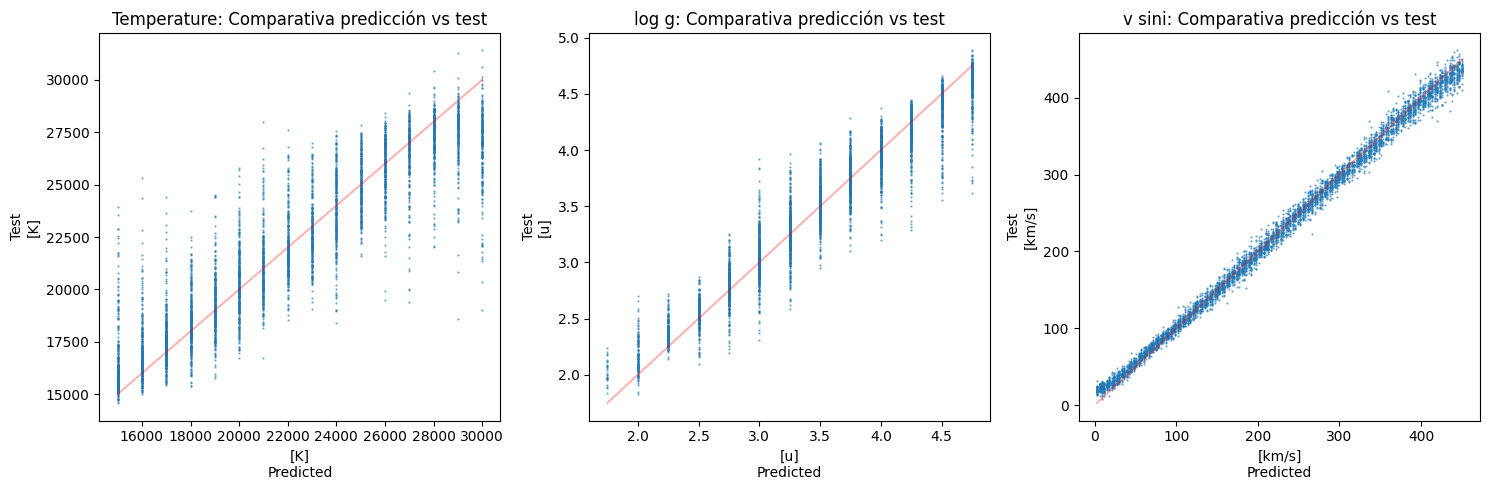

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=predictions[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs test')
 
plt.tight_layout();
plt.show()

c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


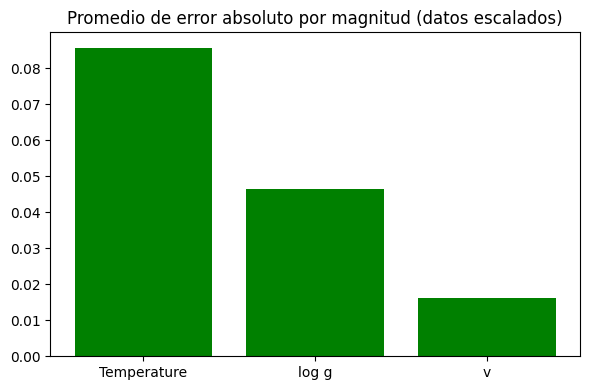

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
x_data = ['Temperature','log g','v']

diff = np.mean(np.abs(y_scaler.transform(predictions)-y_test),axis=0)
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


In [16]:
#data formatting
inverse_y_train = y_scaler.inverse_transform(y_train)
rel_error = np.abs(predictions-inverse_y_train)*(1/inverse_y_train)*100
abs_error = np.abs(predictions-inverse_y_train)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_train[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_train[:,1],0)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_train[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [17]:
# table plot
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,

                    })
results.head(10)

,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
0,16000,15848,152 (1.0%),3.0,2.69,0 (2.0%),159,163,4 (2.6%)
1,16000,16059,59 (0.4%),3.0,3.02,0 (9.9%),324,315,9 (2.7%)
2,20000,19944,56 (0.3%),4.0,4.31,0 (1.3%),111,110,1 (0.6%)
3,24000,25445,1445 (6.0%),3.0,3.64,0 (3.9%),420,420,0 (0.1%)
4,18000,19678,1678 (9.3%),4.0,4.0,0 (0.1%),216,221,5 (2.3%)
5,25000,26447,1447 (5.8%),4.0,3.8,0 (1.4%),348,345,3 (0.9%)
6,16000,16174,174 (1.1%),3.0,2.71,0 (1.3%),162,162,0 (0.0%)
7,21000,19802,1198 (5.7%),4.0,3.76,0 (0.4%),225,224,1 (0.5%)
8,19000,19086,86 (0.5%),3.0,3.05,0 (1.6%),93,95,2 (2.4%)
9,25000,23401,1599 (6.4%),3.0,2.7,0 (1.7%),219,210,9 (3.9%)


### Datos observados vs predicción de modelo único

In [18]:
predictions = y_scaler.inverse_transform(model.predict(formatted_x_obs))

3/3 [==============================] - 0s 5ms/step


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_obs)[:,i].min(), y_scaler.inverse_transform(y_obs)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_obs)[:,i],y=predictions[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Observed\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs observacion')
 
plt.tight_layout();
plt.show()

In [19]:
#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(predictions-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(predictions-inverse_y_obs)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_obs[:,1],0)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [20]:
# tabla de resultados modelo unico sobre datos observados

results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(20)

,date,time,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
HD,,,,,,,,,,,
33328,2012-11-13,05-37-18,19526,16964,2562 (13.1%),3.0,3.4,0 (2.9%),287,276,11 (3.9%)
33328,2013-01-18,03-39-09,19526,17010,2516 (12.9%),3.0,3.64,0 (10.4%),287,292,5 (1.9%)
33328,2013-02-26,00-55-34,19526,18842,684 (3.5%),3.0,3.06,0 (7.3%),287,279,8 (2.8%)
33328,2015-02-25,23-58-07,19526,14503,5023 (25.7%),3.0,4.31,1 (30.5%),287,275,12 (4.1%)
33328,2015-02-26,00-19-03,19526,17712,1814 (9.3%),3.0,3.61,0 (9.3%),287,300,13 (4.4%)
35165,2014-03-20,23-53-54,17000,16112,888 (5.2%),4.0,4.38,0 (9.6%),240,181,59 (24.4%)
35165,2014-03-21,00-14-49,17000,17345,345 (2.0%),4.0,4.11,0 (2.9%),240,213,27 (11.4%)
35165,2014-03-21,00-35-18,17000,16057,943 (5.5%),4.0,4.04,0 (0.9%),240,219,21 (8.8%)
35165,2015-11-14,04-22-43,17000,26172,9172 (54.0%),4.0,3.55,0 (11.2%),240,304,64 (26.7%)


In [21]:
# / TODO ponerle titulo a las cosas 
# / TODO mostrar tabla con datos sintéticos
# / TODO mostrar fdp datos sinteticos
# / TODO mostrar resultados prediccion de datos observados
# TODO distribucion predictiva de datos observados
# / TODO agregar ruido a todas las particiones de x 
# / TODO mostrar el error
# / TODO graficar comparativa de espectro observado con sintetico
# / TODO entender como se llego a la red nuronal
# / TODO volver a generar instancia de entrenamiento de autokeras

# Ensemble

In [22]:
# set timer
curr_time = time.time()

In [23]:
from scipy.sparse import coo_matrix
from sklearn.utils import resample

NUM_MODELS = 20
models = []
history = []

x_train_sparse = coo_matrix(x_train)

for i in range(NUM_MODELS):
	keras.utils.set_random_seed(i)
	am = generateAutoModel()
	x_train_resampled, x_train_sparse, y_train_resampled = resample(x_train, x_train_sparse, y_train, random_state=i)
	x_train_resampled = np.expand_dims(x_train_resampled, axis=2)
	history.append(am.fit(x=x_train_resampled, y=y_train_resampled, epochs=30))
	models.append(am.export_model())

Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 14s 21ms/step - loss: 0.1203 - mae: 0.2804
Epoch 2/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0382 - mae: 0.1482
Epoch 3/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0255 - mae: 0.1184
Epoch 4/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0217 - mae: 0.1079
Epoch 5/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0199 - mae: 0.1031
Epoch 6/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0178 - mae: 0.0968
Epoch 7/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0166 - mae: 0.0934
Epoch 8/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0161 - mae: 0.0913
Epoch 9/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0146 - mae: 0.0866
Epoch 10/30
459/459 [==============================] - 10s 21ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 14s 21ms/step - loss: 0.1114 - mae: 0.2697
Epoch 2/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0355 - mae: 0.1421
Epoch 3/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0244 - mae: 0.1155
Epoch 4/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0210 - mae: 0.1060
Epoch 5/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0190 - mae: 0.1003
Epoch 6/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0177 - mae: 0.0964
Epoch 7/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0170 - mae: 0.0942
Epoch 8/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0154 - mae: 0.0895
Epoch 9/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0155 - mae: 0.0894
Epoch 10/30
459/459 [==============================] - 10s 21ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 14s 21ms/step - loss: 0.1126 - mae: 0.2731
Epoch 2/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0367 - mae: 0.1443
Epoch 3/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0245 - mae: 0.1150
Epoch 4/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0209 - mae: 0.1058
Epoch 5/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0186 - mae: 0.0986
Epoch 6/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0182 - mae: 0.0980
Epoch 7/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0163 - mae: 0.0920
Epoch 8/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0156 - mae: 0.0896
Epoch 9/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0148 - mae: 0.0869
Epoch 10/30
459/459 [==============================] - 10s 21ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 14s 21ms/step - loss: 0.1188 - mae: 0.2788
Epoch 2/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0380 - mae: 0.1467
Epoch 3/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0245 - mae: 0.1150
Epoch 4/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0208 - mae: 0.1050
Epoch 5/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0195 - mae: 0.1015
Epoch 6/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0182 - mae: 0.0977
Epoch 7/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0172 - mae: 0.0947
Epoch 8/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0157 - mae: 0.0905
Epoch 9/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0150 - mae: 0.0880
Epoch 10/30
459/459 [==============================] - 10s 21ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 14s 21ms/step - loss: 0.1094 - mae: 0.2709
Epoch 2/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0384 - mae: 0.1481
Epoch 3/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0238 - mae: 0.1142
Epoch 4/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0209 - mae: 0.1056
Epoch 5/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0190 - mae: 0.1003
Epoch 6/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0172 - mae: 0.0949
Epoch 7/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0168 - mae: 0.0934
Epoch 8/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0155 - mae: 0.0891
Epoch 9/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0149 - mae: 0.0876
Epoch 10/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0142 - mae:

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 14s 21ms/step - loss: 0.1170 - mae: 0.2790
Epoch 2/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0375 - mae: 0.1460
Epoch 3/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0241 - mae: 0.1136
Epoch 4/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0217 - mae: 0.1077
Epoch 5/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0196 - mae: 0.1021
Epoch 6/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0187 - mae: 0.0990
Epoch 7/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0172 - mae: 0.0947
Epoch 8/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0162 - mae: 0.0919
Epoch 9/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0152 - mae: 0.0886
Epoch 10/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0148 - mae

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 14s 21ms/step - loss: 0.1083 - mae: 0.2708
Epoch 2/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0432 - mae: 0.1580
Epoch 3/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0255 - mae: 0.1178
Epoch 4/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0216 - mae: 0.1075
Epoch 5/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0199 - mae: 0.1027
Epoch 6/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0188 - mae: 0.0996
Epoch 7/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0176 - mae: 0.0957
Epoch 8/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0165 - mae: 0.0923
Epoch 9/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0166 - mae: 0.0928
Epoch 10/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0154 - mae

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 14s 22ms/step - loss: 0.1108 - mae: 0.2710
Epoch 2/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0391 - mae: 0.1493
Epoch 3/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0238 - mae: 0.1131
Epoch 4/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0209 - mae: 0.1053
Epoch 5/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0192 - mae: 0.1003
Epoch 6/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0183 - mae: 0.0975
Epoch 7/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0170 - mae: 0.0937
Epoch 8/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0156 - mae: 0.0892
Epoch 9/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0149 - mae: 0.0869
Epoch 10/30
459/459 [==============================] - 10s 21ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 14s 21ms/step - loss: 0.1059 - mae: 0.2662
Epoch 2/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0389 - mae: 0.1496
Epoch 3/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0255 - mae: 0.1174
Epoch 4/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0217 - mae: 0.1082
Epoch 5/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0191 - mae: 0.1007
Epoch 6/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0182 - mae: 0.0974
Epoch 7/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0176 - mae: 0.0957
Epoch 8/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0166 - mae: 0.0925
Epoch 9/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0160 - mae: 0.0908
Epoch 10/30
459/459 [==============================] - 10s 21ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 14s 21ms/step - loss: 0.1125 - mae: 0.2741
Epoch 2/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0366 - mae: 0.1444
Epoch 3/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0250 - mae: 0.1169
Epoch 4/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0209 - mae: 0.1056
Epoch 5/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0186 - mae: 0.0989
Epoch 6/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0184 - mae: 0.0983
Epoch 7/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0166 - mae: 0.0928
Epoch 8/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0158 - mae: 0.0900
Epoch 9/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0148 - mae: 0.0868
Epoch 10/30
459/459 [==============================] - 10s 21ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 13s 21ms/step - loss: 0.1037 - mae: 0.2628
Epoch 2/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0364 - mae: 0.1433
Epoch 3/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0246 - mae: 0.1159
Epoch 4/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0208 - mae: 0.1055
Epoch 5/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0188 - mae: 0.0995
Epoch 6/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0171 - mae: 0.0948
Epoch 7/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0160 - mae: 0.0910
Epoch 8/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0154 - mae: 0.0898
Epoch 9/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0153 - mae: 0.0887
Epoch 10/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0142 - mae

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 14s 21ms/step - loss: 0.1025 - mae: 0.2594
Epoch 2/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0372 - mae: 0.1455
Epoch 3/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0242 - mae: 0.1147
Epoch 4/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0209 - mae: 0.1057
Epoch 5/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0189 - mae: 0.0998
Epoch 6/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0179 - mae: 0.0968
Epoch 7/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0169 - mae: 0.0938
Epoch 8/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0158 - mae: 0.0901
Epoch 9/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0148 - mae: 0.0874
Epoch 10/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0147 - mae:

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 13s 21ms/step - loss: 0.1095 - mae: 0.2697
Epoch 2/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0392 - mae: 0.1499
Epoch 3/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0241 - mae: 0.1138
Epoch 4/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0207 - mae: 0.1048
Epoch 5/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0194 - mae: 0.1009
Epoch 6/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0173 - mae: 0.0946
Epoch 7/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0165 - mae: 0.0923
Epoch 8/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0157 - mae: 0.0898
Epoch 9/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0152 - mae: 0.0883
Epoch 10/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0140 - mae

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 13s 21ms/step - loss: 0.1189 - mae: 0.2791
Epoch 2/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0397 - mae: 0.1510
Epoch 3/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0243 - mae: 0.1144
Epoch 4/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0211 - mae: 0.1060
Epoch 5/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0191 - mae: 0.1004
Epoch 6/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0181 - mae: 0.0973
Epoch 7/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0165 - mae: 0.0928
Epoch 8/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0161 - mae: 0.0911
Epoch 9/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0151 - mae: 0.0879
Epoch 10/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0148 - m

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 14s 21ms/step - loss: 0.1192 - mae: 0.2787
Epoch 2/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0360 - mae: 0.1432
Epoch 3/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0252 - mae: 0.1174
Epoch 4/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0214 - mae: 0.1070
Epoch 5/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0199 - mae: 0.1027
Epoch 6/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0179 - mae: 0.0974
Epoch 7/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0180 - mae: 0.0979
Epoch 8/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0159 - mae: 0.0908
Epoch 9/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0153 - mae: 0.0891
Epoch 10/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0145 - mae

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 14s 21ms/step - loss: 0.1128 - mae: 0.2728
Epoch 2/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0357 - mae: 0.1421
Epoch 3/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0239 - mae: 0.1141
Epoch 4/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0207 - mae: 0.1055
Epoch 5/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0185 - mae: 0.0987
Epoch 6/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0171 - mae: 0.0946
Epoch 7/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0161 - mae: 0.0917
Epoch 8/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0154 - mae: 0.0896
Epoch 9/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0151 - mae: 0.0881
Epoch 10/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0150 - mae:

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 14s 21ms/step - loss: 0.1125 - mae: 0.2722
Epoch 2/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0418 - mae: 0.1551
Epoch 3/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0253 - mae: 0.1174
Epoch 4/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0208 - mae: 0.1053
Epoch 5/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0189 - mae: 0.1000
Epoch 6/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0178 - mae: 0.0963
Epoch 7/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0166 - mae: 0.0928
Epoch 8/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0165 - mae: 0.0927
Epoch 9/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0156 - mae: 0.0895
Epoch 10/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0146 - mae

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 14s 21ms/step - loss: 0.1121 - mae: 0.2726
Epoch 2/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0386 - mae: 0.1482
Epoch 3/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0247 - mae: 0.1159
Epoch 4/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0210 - mae: 0.1061
Epoch 5/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0188 - mae: 0.0993
Epoch 6/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0178 - mae: 0.0970
Epoch 7/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0161 - mae: 0.0913
Epoch 8/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0161 - mae: 0.0913
Epoch 9/30
459/459 [==============================] - 9s 20ms/step - loss: 0.0148 - mae: 0.0873
Epoch 10/30
459/459 [==============================] - 9s 21ms/step - loss: 0.0139 - mae:

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 14s 21ms/step - loss: 0.1134 - mae: 0.2756
Epoch 2/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0410 - mae: 0.1536
Epoch 3/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0241 - mae: 0.1142
Epoch 4/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0209 - mae: 0.1058
Epoch 5/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0190 - mae: 0.1003
Epoch 6/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0178 - mae: 0.0968
Epoch 7/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0167 - mae: 0.0932
Epoch 8/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0159 - mae: 0.0903
Epoch 9/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0148 - mae: 0.0871
Epoch 10/30
459/459 [==============================] - 10s 21ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 14s 22ms/step - loss: 0.1078 - mae: 0.2663
Epoch 2/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0376 - mae: 0.1456
Epoch 3/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0242 - mae: 0.1144
Epoch 4/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0214 - mae: 0.1067
Epoch 5/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0191 - mae: 0.1000
Epoch 6/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0173 - mae: 0.0948
Epoch 7/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0165 - mae: 0.0921
Epoch 8/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0158 - mae: 0.0899
Epoch 9/30
459/459 [==============================] - 10s 21ms/step - loss: 0.0153 - mae: 0.0883
Epoch 10/30
459/459 [==============================] - 10s 22ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


In [24]:
# execution time print
print_time(float(time.time() - curr_time))

--- Total: 1 hours, 40 minutes, 52.652065 seconds  ---


In [25]:
# prediccion de datos observados
predictions = np.array([y_scaler.inverse_transform(model.predict(formatted_x_test)) for model in models]) # dim(predictions) = (num_models, num_rows, num_outputs)

153/153 [==============================] - 1s 6ms/step


In [26]:
# prediccion del ensamble e incerteza
weights = [model.evaluate(formatted_x_test, y_test)[0] for model in models]
weights = [weight/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])**(1/2)


153/153 [==============================] - 2s 8ms/step - loss: 0.0059 - mae: 0.0466


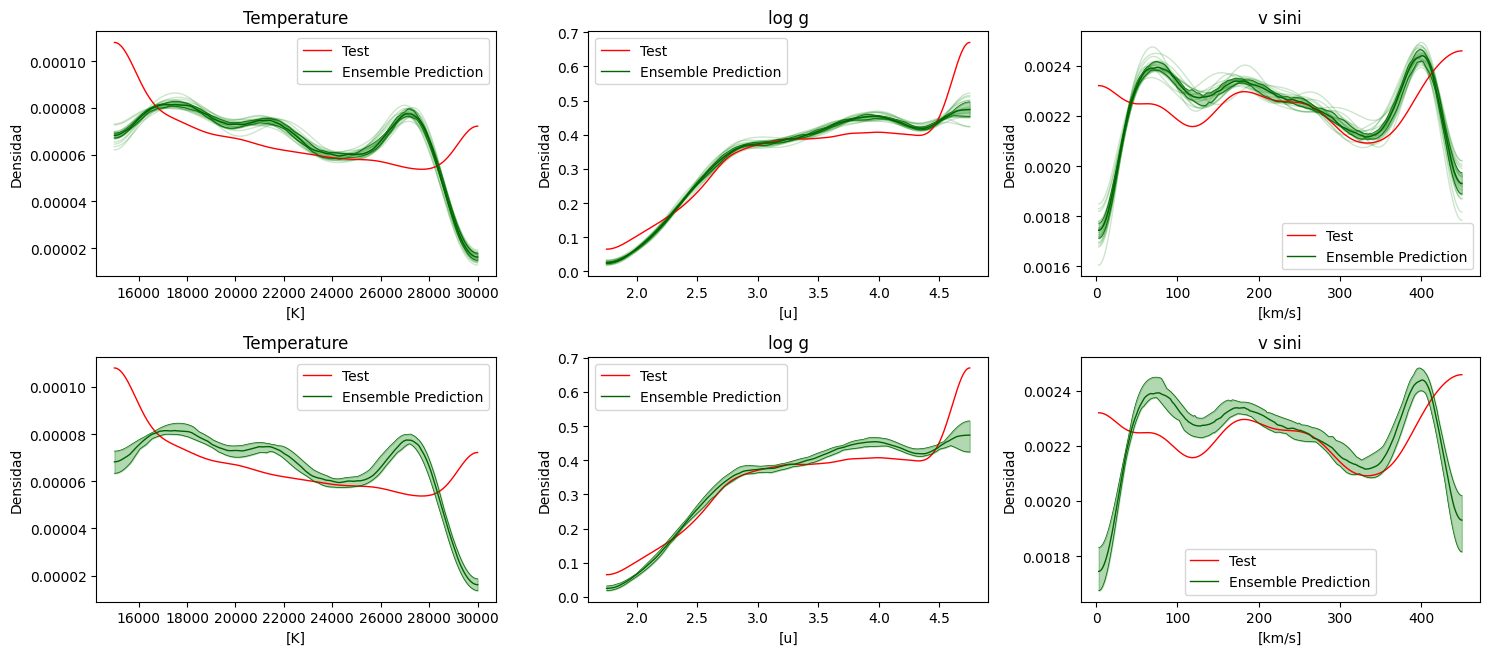

In [27]:
# Ref: https://stackoverflow.com/questions/60130503/plotting-bars-hist-and-pdf-line-via-kdeplot
import scipy.stats as st
from scipy.interpolate import interp1d

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,6.66))

for i, featureName in enumerate(target):
	x_space = np.linspace(Y[featureName].min(), Y[featureName].max(), 2**12)
	heights = []
	for j in range(NUM_MODELS):
		prediction_y = predictions[j,:,i] # your data goes here
		x,y,prediction_kde = SKL_density_plot(prediction_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',alpha=0.2)
		f = interp1d(x, y, kind="linear", assume_sorted=True)
		h = f(x_space)*3
		heights.append(h)
  
	heights = np.array(heights)
 
	rescaled_y = y_scaler.inverse_transform(y_test)[:,i]
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[1,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	f = interp1d(x, y, kind="linear", assume_sorted=True)
	test_h = f(x_space)
 
	# cuantiles 50% de los datos
	q25 = np.quantile(heights,0.25,axis=0)
	q75 = np.quantile(heights,0.75,axis=0)
	axes[0,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[0,i].plot(x_space, q25,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].plot(x_space, q75,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].fill_between(x_space, q25,q75, alpha=0.30, color='green')
	
	# cuantiles 95% de los datos
	q5 = np.quantile(heights,0.05,axis=0)
	q95 = np.quantile(heights,0.95,axis=0)
	axes[1,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[1,i].plot(x_space, q5,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].plot(x_space, q95,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].fill_between(x_space, q5,q95, alpha=0.30, color='green')
	
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[u]', '[km/s]']
	axes[1,i].set_xlabel(measure_unit[i])
	axes[1,i].set_ylabel('Densidad')
	axes[1,i].legend()
	axes[1,i].set_title(measure[i])

	axes[0,i].set_xlabel(measure_unit[i])
	axes[0,i].set_ylabel('Densidad')
	axes[0,i].legend()
	axes[0,i].set_title(measure[i])


plt.tight_layout()
plt.show()

# Datos de testing vs prediccion(ensamble)

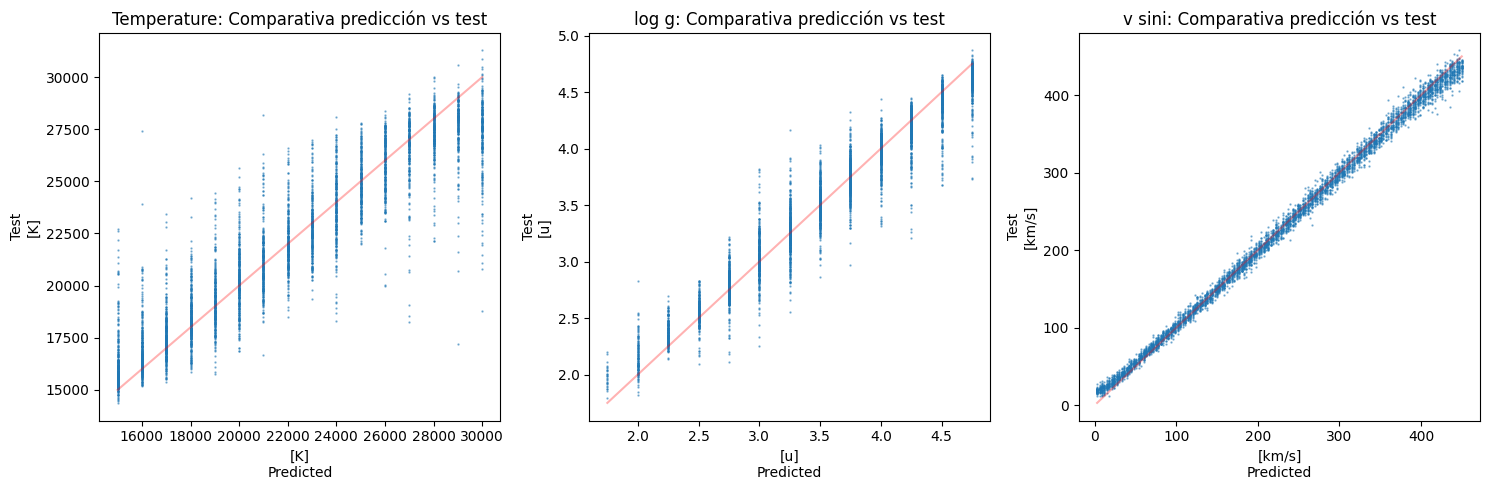

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=ensemble_prediction[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs test')
 
plt.tight_layout();
plt.show()

c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\

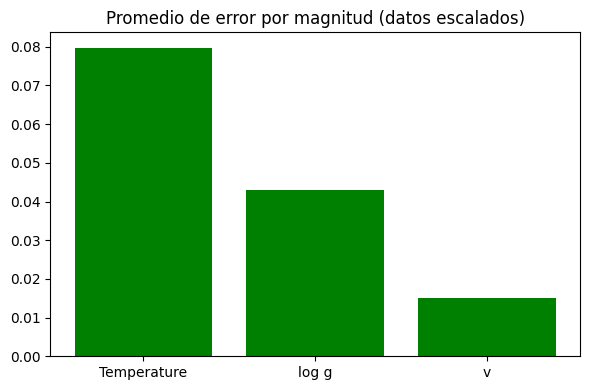

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=4,4))
x_data = ['Temperature','log g','v']

diff = np.mean(np.array([np.abs(y_scaler.transform(y_hat)-y_test) for y_hat in predictions]),axis=(0,1))
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


In [30]:
# / TODO Error relativo-absoluto agregado en la tabla
# / TODO scatter de valor esperado sobre prediccion
# TODO graficar comparativa entre estrella sitentica y real
# TODO grafica con vecindario de espectro real

In [31]:
# dataframe
inverse_y_test = y_scaler.inverse_transform(y_test)
results = pd.DataFrame({
  'Temp':inverse_y_test[:,0],'Temp_pred':ensemble_prediction[:,0],'Temp_Variance':uncertainty[:,0],
  'log_g':inverse_y_test[:,1],'log_g_pred':ensemble_prediction[:,1],'log_g_Variance':uncertainty[:,1],
  'v':inverse_y_test[:,2],'v_pred':ensemble_prediction[:,2],'v_Variance':uncertainty[:,2]
                    })
results.head(10)

,Temp,Temp_pred,Temp_Variance,log_g,log_g_pred,log_g_Variance,v,v_pred,v_Variance
0,17000.0,17462.402344,133.749832,3.25,3.304330,0.035198,246.0,242.488159,3.297354
1,18000.0,16410.287109,204.994858,2.75,2.629919,0.036332,285.0,282.311218,4.779276
2,30000.0,26825.376953,342.408966,3.75,3.575382,0.035575,267.0,265.339600,3.192844
3,23000.0,20887.076172,305.847137,2.50,2.462493,0.032040,63.0,69.819565,3.474415
4,19000.0,20069.263672,236.553986,3.00,3.053489,0.029009,126.0,138.870667,3.682142
5,17000.0,16863.353516,124.724403,4.50,4.398975,0.041798,156.0,155.314743,3.563095
6,28000.0,22306.666016,331.588043,3.25,2.842904,0.039857,450.0,434.889343,5.586120
7,22000.0,20843.500000,240.042603,4.00,4.054980,0.027766,285.0,285.319855,2.043837
8,23000.0,23888.232422,264.710541,3.00,3.000470,0.022854,30.0,40.177654,2.220385
9,23000.0,22829.431641,217.465607,4.50,4.456311,0.023184,153.0,160.364380,3.132248


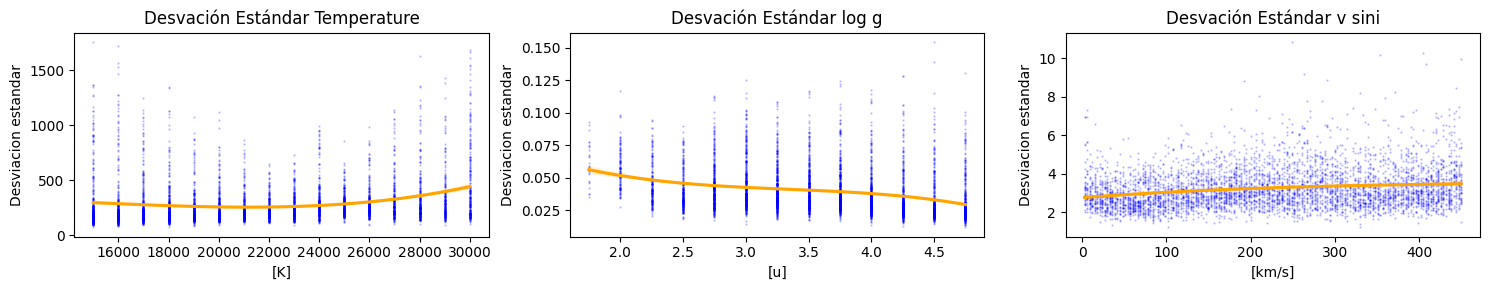

In [32]:
# TODO: algo que permita ver el tamano de las varianzas sobre target feature
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
feat=['Temp', 'log_g',	'v']
vari=['Temp_Variance','log_g_Variance','v_Variance']
measure = ['Temperature','log g', 'v sini']
measure_unit = ['[K]', '[u]', '[km/s]']

for i, featureName in enumerate(target):
	x_data = y_scaler.inverse_transform(y_test)[:,i]
	y_data = uncertainty[:,i]
	sns.regplot(x=feat[i], y=vari[i], data=results,ax=axes[i],scatter_kws=dict(alpha=0.2,color='blue',s=0.5),line_kws=dict(color='orange'), order=3);
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel("Desviacion estandar")
	axes[i].set_title('Desvación Estándar '+measure[i])
	#axes[i].legend()
  
plt.tight_layout()
plt.show()

### Datos observados vs predicción (ensamble)

In [33]:
# generar predicciones e incerteza de ensamble
predictions = np.array([y_scaler.inverse_transform(model.predict(formatted_x_obs)) for model in models])
ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])**(1/2)

3/3 [==============================] - 0s 34ms/step


In [34]:
# data processing for formatted table

# error sign: ±

table_formatted_temperature_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,0],uncertainty[:,0])]
table_formatted_log_g_pred = [str(round(i,2))+' ± '+str(round(j,2)) for i,j in zip(ensemble_prediction[:,1],uncertainty[:,1])]
table_formatted_v_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,2],uncertainty[:,2])]

#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(ensemble_prediction-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(ensemble_prediction-inverse_y_obs)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_obs[:,1],0)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(np.round(i,2))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [35]:
# dataframe comparativo de datos observados
inverse_y_obs = y_scaler.inverse_transform(y_obs)
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temperatura':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(60)

,date,time,Temperatura,Prediccion_Temperatura,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
HD,,,,,,,,,,,
33328,2012-11-13,05-37-18,19526,16832 ± 257,2694.0 (13.8%),3.0,3.36 ± 0.1,0.06 (1.8%),287,268 ± 7,19.0 (6.7%)
33328,2013-01-18,03-39-09,19526,16507 ± 372,3019.0 (15.5%),3.0,3.65 ± 0.13,0.35 (10.7%),287,285 ± 8,2.0 (0.7%)
33328,2013-02-26,00-55-34,19526,19405 ± 216,121.0 (0.6%),3.0,3.1 ± 0.03,0.2 (5.9%),287,268 ± 7,19.0 (6.5%)
33328,2015-02-25,23-58-07,19526,14868 ± 580,4658.0 (23.9%),3.0,3.76 ± 0.22,0.46 (13.9%),287,299 ± 15,12.0 (4.0%)
33328,2015-02-26,00-19-03,19526,17521 ± 392,2005.0 (10.3%),3.0,3.52 ± 0.12,0.22 (6.8%),287,291 ± 7,4.0 (1.4%)
35165,2014-03-20,23-53-54,17000,17805 ± 569,805.0 (4.7%),4.0,3.69 ± 0.2,0.31 (7.9%),240,245 ± 12,5.0 (2.2%)
35165,2014-03-21,00-14-49,17000,18221 ± 432,1221.0 (7.2%),4.0,3.69 ± 0.16,0.31 (7.8%),240,236 ± 12,4.0 (1.9%)
35165,2014-03-21,00-35-18,17000,16681 ± 684,319.0 (1.9%),4.0,3.64 ± 0.25,0.36 (9.1%),240,231 ± 14,9.0 (3.7%)
35165,2015-11-14,04-22-43,17000,24091 ± 758,7091.0 (41.7%),4.0,3.54 ± 0.11,0.46 (11.4%),240,273 ± 7,33.0 (13.9%)


In [36]:
# total execution time print
execution_time = float(time.time() - start_time)
print_time(execution_time)

--- Total: 1 hours, 48 minutes, 1.890691 seconds  ---
